<figure>
  <IMG SRC="https://raw.githubusercontent.com/mbakker7/exploratory_computing_with_python/master/tudelft_logo.png" WIDTH=300 ALIGN="right">
</figure>

# EO1 Statistical Geo-Data Analysis


## Project on Estimation, Testing and DIA Theory

### Introduction
In this project, we will model the sea level rise making use of the **estimation**, **testing** and **DIA** (Detection, Identification and Adaptation) theory. We are simplifying the observations to 1-Dimension, focusing on heights (_measurements of tide gauges_) at different times. The assignment consists of three parts:

1. **Estimation Part**: You will estimate the drift parameters with different models and estimators. Make sure to compare and explain your results.
2. **Testing Part**: You will apply the testing theory to select the model that best fits the observations.
3. **DIA Part**: You will formulate the DIA estimator and explore its properties. 

_Some guidelines to keep in mind_:
- We do not require a separate report; all code and answers should be within this Notebook.
- Your code and answers should be self-contained, i.e. explain how you obtained your results.
- The analysis and interpretation of your results are at least equally important as the results themselves (numerical solutions and plots).
- Include the plots that you are asked to make. Ensure that the plots include axis labels with appropriate units.
- Print the numerical results, with units and proper number of significant digits.

### Objectives
In this assignment you will learn to:
- Set up the linear observation models,
- Understand the differences and connections between LS, WLS and BLUE,
- Solve the conditioned and constrained linear model,
- Select the best fit model with statistical testing theory,
- Formulate a DIA estimator,
- Analyze the properties of a DIA estimator.

In [1]:
# Import Modules
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from scipy.stats.distributions import chi2

## 0. Preparation

### 0.1. Import Data

In this project, you will work with a time series of mean sea level observations at a specific location. The monthly mean sea level observations start from 1981 and span 40 years, ending at 2020. We provide the datasets of the following locations and you can choose one of them for this assignment. 
- [Delfzijl](SGDA_Delfzijl_MSL.csv)
- [Harlingen](SGDA_Harlingen_MSL.csv)
- [Den Helder](SGDA_Den_Helder_MSL.csv)
- [Ijmuiden](SGDA_Ijmuiden_MSL.csv)
- [Hoek van Holland](SGDA_Hoek_van_Holland_MSL.csv)
- [Maassluis](SGDA_Maassluis_MSL.csv)
- [Vlissingen](SGDA_Vlissingen_MSL.csv)

The dataset of each station contains a time series ($2^{\text{nd}}$ column), $t$ in [month], the sea level observation vector ($3^{\text{rd}}$ column), $y$ in [m], and standard deviation of the measurement ($4^{\text{th}}$ column), $\sigma_{y}$ in [m]. 
Please load and visualize your data from SGDA_[location]_MSL.csv. **Make a plot showing $y$ _vs_ $t$**:

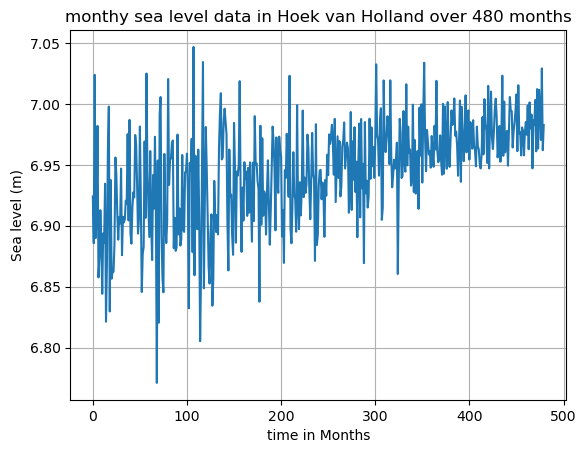

In [2]:
# Add your code here to load and visualize the data
# Import data
Data = np.genfromtxt('Datasets/SGDA_Hoek_van_Holland_MSL.csv',delimiter=',', skip_header=1)

y = Data[:,2]
month = Data[:,1]
mean_sea_level = Data[:,2]
STD = Data[:,3]

plt.plot(month, mean_sea_level)
plt.title('monthy sea level data in Hoek van Holland over 480 months')
plt.ylabel('Sea level (m)')
plt.xlabel('time in Months')
plt.grid()

**Answer the following questions:**

- Describe your plot (i.e., which conclusions do you draw about data, noise, trend?)

**The plot shows monthly sea level data in Hoek van Holland over 480 months. Observations suggest variability around a slowly increasing trend, indicating a rise in sea level over time (around 10 cm throughout this period). Noise appears significant, as indicated by the vertical spread around the trend; possibility due to environmental factors or measurement error. We do see that the presicion is getting better over time which has an effect on the noise. You can you the noise decreases over time due to better presicionin measurement**

### 0.2. Set up $Q_{yy}$

**Answer the following questions:**

- Please create the variance-covariance matrix of the observations ($Q_{yy}$) in which all the observables are independent and follow the normal distribution. __Note__: The $4^{\text{th}}$ column of the dataset gives the standard deviation of each measurement. 
- Could you provide the dimensions of the observable vector $y$ and the $Q_{yy}$-matrix? Additionally, could you print the $Q_{yy}$-matrix?

(480,) (480, 480)
[[0.0025 0.     0.     ... 0.     0.     0.    ]
 [0.     0.0025 0.     ... 0.     0.     0.    ]
 [0.     0.     0.0025 ... 0.     0.     0.    ]
 ...
 [0.     0.     0.     ... 0.0004 0.     0.    ]
 [0.     0.     0.     ... 0.     0.0004 0.    ]
 [0.     0.     0.     ... 0.     0.     0.0004]]
we have 480 observations (m).The vector y is (480x1) and the Q_{yy} matrix is a square 480x480 matrix


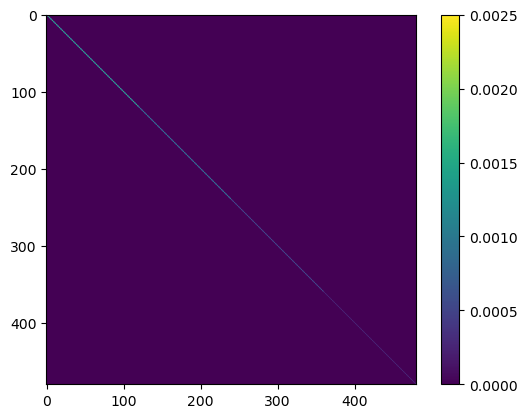

In [3]:
# Print and check your Q_yy here
Q_yy= np.diag(Data[:,3]*Data[:,3])
print(y.shape, Q_yy.shape)
print(Q_yy)
print('we have 480 observations (m).The vector y is (480x1) and the Q_{yy} matrix is a square 480x480 matrix')
plt.imshow(Q_yy)
plt.colorbar()
plt.show()

**The observable vector $y$ is a 1d vector with 480 observations. The $Q_{yy}$ matrix is 480 x 480.**


## 1. Estimation
In this part of the project, you will fit the observations with different models and estimators. 

### 1.1. Default Model
We want to investigate how we could model the observations. From the plot of the mean sea level vs. time, we can see that the height is somewhat linearly increasing with time. We assume it can be modeled using a constant change rate $\alpha$ and a bias $\beta$. The model is defined as 
$$
y(t) = \alpha t + \beta 
$$
where $y(t)$ is the observations as a function of the known observation time $t$. Based on this model, please construct the functional model for estimation that is defined as 
$$
\mathbb{E}(\underline{y}) = A_0x_0.
$$

**Answer the following questions:**
- What are the unknowns of the functional model? What is the dimension of the unknown parameter vector $x_0$?
    - The unknowns are the constant rate of change of the sea level over time and the intercept, representing the sea level at $t=0$. The dimensions of $x_0$ is 2 ,[$\alpha, \beta$].

- What do you put in the columns of the $A_0$ matrix?
    - The first column correspond to time, or the months from 1 to 480. The second column are all ones.

- What is the redundancy $r$ for this model? 
    - $r = n - u$. 480 - 2 = 478.

- Construct the design matrix $A_0$, print the first 5 rows.

In [4]:
#Construct the design matrix A0​, print the first 5 rows
A0= np.ones((month.size,2))
A0[:,0]=month

print(A0[0:5,:])


[[0. 1.]
 [1. 1.]
 [2. 1.]
 [3. 1.]
 [4. 1.]]


#### 1.1.1. Use BLUE to Estimate the Unknown Parameter $x$

BLUE will be used several times in our project. Thus, we can define a function of BLUE. **Please finish the BLUE function below**:

In [5]:
def BLUE(A,y,Q_yy):
    """ 
    Function to calculate the Best Linear Unbiased Estimator  
    """

    # Add your code here
    inv_Q_yy= np.linalg.inv(Q_yy)
    Q_x_hat = np.linalg.inv(A.T @ inv_Q_yy @ A)
    x_hat = np.linalg.solve(A.T @ inv_Q_yy @ A, A.T @ inv_Q_yy @ y)

    return x_hat, Q_x_hat

**Answer the following questions:**
- Print the value/s of $\hat{x}$ and also indicate its units.
- Print the standard deviations of $\hat{x}$ along with its units.
- If $\hat{x}$ is a vector with more than one value, give the correlation coefficient between the unknown parameters.

In [6]:
# Obtain the estimate of x_0 with BLUE
x_hat, Q_x_hat = BLUE(A0, mean_sea_level, Q_yy)

# Print estimated parameters with units
print(f'Estimated rate of change (α): {x_hat[0]:.5f} m/month, Initial bias (β): {x_hat[1]:.2f} m.')

# Calculate standard deviations from the diagonal of Q_x_hat
std_devs = np.sqrt(np.diagonal(Q_x_hat))
print(f'Standard deviations: Rate of change (α): {std_devs[0]:.6f} m/month, Initial bias (β): {std_devs[1]:.5f} m')

# Calculate correlation coefficient from Q_x_hat
correlation_coefficient = Q_x_hat[0, 1] / (std_devs[0] * std_devs[1])
print(f'Correlation coefficient between α and β: {correlation_coefficient:.5f}')

Estimated rate of change (α): 0.00017 m/month, Initial bias (β): 6.90 m.
Standard deviations: Rate of change (α): 0.000011 m/month, Initial bias (β): 0.00381 m
Correlation coefficient between α and β: -0.93620


#### 1.1.2. Reflect on Estimation Results

**Compute** the modeled height ($\hat{y}$), and the residuals ($\hat{e}=y-\hat{y}$). **Create** a function to generate the following three plots:
1. $y$ and $\hat{y}$ vs. $t$,
2. $\hat{e}$ vs. $t$, with 99% confidence interval,
3. Histogram of the normalized residuals $\hat{e}_i/\sigma_{\hat{e}_i}$ (pay attention to the number of bins) and the PDF of the corresponding normal distribution (as you would expect it).

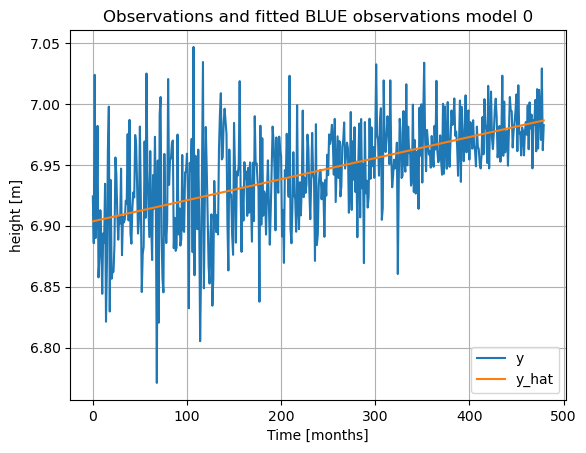

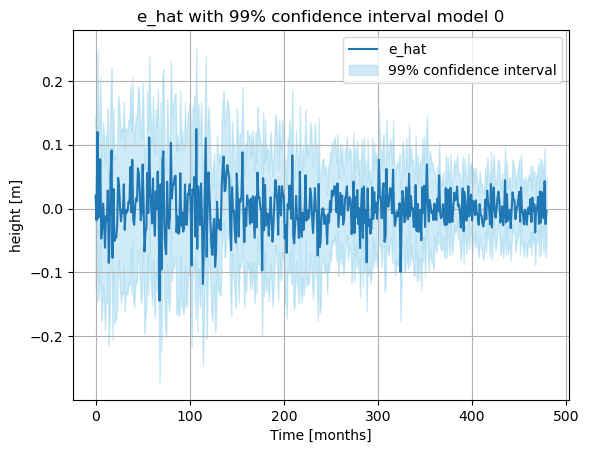

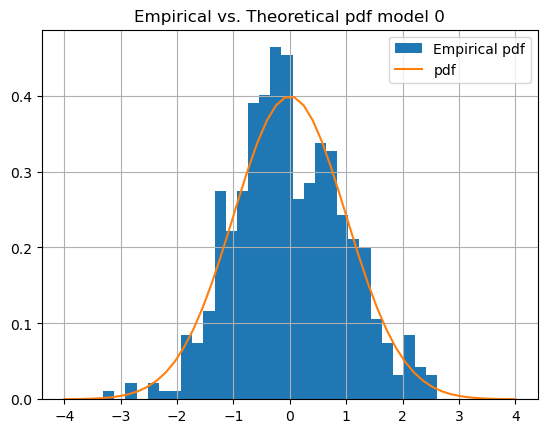

In [7]:
# Functions to compute and plot y_hat and e_hat
def plot_result(y, A0, Q_yy, months, model):
    [x_hat, Q_x_hat] = BLUE(A0, y, Q_yy)
    y_hat = A0 @ x_hat
    e_hat = y - y_hat
    plt.plot(months, y, label='y')
    plt.plot(months, y_hat, label='y_hat')
    plt.legend()
    plt.title(f'Observations and fitted BLUE observations {model}')
    plt.xlabel('Time [months]')
    plt.ylabel('height [m]')
    plt.grid()
    
    plt.figure()
    plt.plot(months, e_hat, label='e_hat')
    
    PA = A0 @ np.linalg.inv(A0.T @ np.linalg.inv(Q_yy) @ A0) @ A0.T @ np.linalg.inv(Q_yy)
    PA_1 = np.eye(len(y)) - PA
    Q_ehat = PA_1 @ Q_yy @ PA_1.T
    sigma_ehat = np.diag(Q_ehat)**.5
    ehat_int = norm.ppf(.995, scale = sigma_ehat )
    ehatplus = e_hat + ehat_int
    ehatmin = e_hat - ehat_int

    plt.fill_between(months, ehatplus, ehatmin, color='skyblue', alpha=0.4, label='99% confidence interval')
    plt.legend()
    plt.title(f'e_hat with 99% confidence interval {model}')
    plt.xlabel('Time [months]')
    plt.ylabel('height [m]')
    plt.grid()
    
    e_hat_norm = e_hat/sigma_ehat
    plt.figure()
    plt.title(f'Empirical vs. Theoretical pdf {model}')
    plt.hist(e_hat_norm, bins=30, density=True, label='Empirical pdf')
    plt.plot(np.linspace(-4, 4), norm.pdf(np.linspace(-4, 4)), label='pdf')
    plt.grid()
    plt.legend()
    return e_hat
# Plot the results with your function
# Q_yy
e_hat = plot_result(y, A0, Q_yy, month, 'model 0')

**Answer the following questions:**
- How do you compute $\hat{y}$?
    - $\hat{y} = A_0 \hat{x}$
- How do you compute $Q_{\hat{e}\hat{e}}$?
    - $Q_{\hat{e}\hat{e}} = PA_1 Q_{yy} PA_1^t$
- How do you obtain the 99% confidence region of $\hat{e}$?
    - Compute the standard deviation of the residuals from $Q_{\hat{e}\hat{e}}$ and use it as the z-score that corresponds to the 99% confidence interval.
- Why do we make a histogram of the <b>normalized</b> residuals?
    - So that we can directly compare the residuals across different observations or different models, irrespective of the scale of the measurements. 

__Answer__

#### 1.1.3. Analyze the Results

**Answer the following questions:**
- What are the mean and empirical standard deviation of the normalized residuals?
    - The mean is 0.0029 [-] and the empirical standard deviation is 0.98 m.
- Compare the histogram of the normalized residuals with the standard normal distribution. What can you conclude?
    - The standard normal distribution seems to fit well the histogram; however, we see that the histogram is higher a bit before zero and lower a bit after zero, suggesting some deviation from normality around the mean.
- When you plot the residuals $\hat{e}$ vs time $t$, do you see any systematic effect? Give your interpretation.
    - We do not see any systematic effect nor trend over time, the residuals seem to be randomly spread around 0. We see however that their amplitude seems to reduce a bit after $\sim$ 250 months.
- Do you think the default model fit the observations? Why?
    - Yes. Although it is a simple linear model, we see that the residuals are randomly distributed around zero; with an acceptable magnitude of around 0.1 m which is a small fraction of the total sea level ($\sim$ 7 m). Furthermore, the normalized residuals histogram seem to fit reasonably well under the standard normal distribution.

#### 1.1.4. Conditioned Linear Model

We have obtained $\hat{y}$ based on the parametric model with BLUE, while it can also be obtained by solving the conditioned model. Please formulate the conditioned linear model and obtain $\hat{y}$ with it. 

**Answer the following questions:**
- What is the dimension of the $B$ matrix?
- How do you formulate your $B$ matrix? (Find a proper $B$ matrix by yourself manually instead of using a _Python_ function. Hint: you can start with finding a structure of $B$ for the first column of $A_0$)
- Explain why do you think your $B$ matrix is a correct one.
- How do you solve the conditioned linear model?
- Compare your results with that obtained from the parametric model.

The dimension of the B matrix is $m \times (m-n)= 480 \times 478$

Using the property that $B^T A= 0$ We found a B matrix that uses the pattern $[-1,1,1,-1,0...0]$ 

$$
B^T= \begin{pmatrix}
-1 & 2 & -1 & 0 & 0 & \cdots & \cdots & \cdots & 0 & 0 \\
-1 & 1 & 1 & -1 & 0 & \cdots& \cdots & \cdots & 0 & 0 \\
0  & -1 & 1 & 1 & -1 & 0& \cdots & \cdots & 0 & 0 \\
0 & 0  & -1 & 1 & 1 & -1 & 0 & \cdots & 0 & 0  \\
\vdots  & \vdots & \vdots & \vdots & \ddots & \ddots & \ddots & \ddots & \vdots & \vdots  \\
\vdots  & \vdots & \vdots & \vdots & \vdots & \ddots & \ddots & \ddots & \ddots & \vdots  \\
\vdots  & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \ddots & \ddots & \ddots  \\
0 & 0 & 0 & 0 & 0 &\cdots & -1 & 1 & 1 &-1 \\

\end{pmatrix} \hspace{5mm} \text{size: }478 \times 480
$$


The B matrix is correct, because it fullfills the property $B^T A_0=0$ as shown in the code below

Solving the conditioned model: 
$$B^T E(y)= b_0$$

$$\hat{y}= y-Q_{yy}B(B^T Q_{yy}B)^{-1}(B^T y-b_0)$$

In [8]:
m = A0.shape[0]
n = A0.shape[1]
r = m - n
B_T = np.zeros([m, r]).T

for i in range(r):
    if i == 0:
        B_T[i, i:i+3]= np.array([-1, 2, -1])
    else:
        B_T[i, i-1:i+3]= np.array([1, -1, -1, 1])
# A0
print(f'Rank of B^T should be r = {r}, rank = {np.linalg.matrix_rank(B_T.T)}')
print(f'check if all elements in B^T A = 0:  {np.all((B_T@A0)==0)}')
print(B_T)
B= B_T.T
print(B.shape)

Rank of B^T should be r = 478, rank = 478
check if all elements in B^T A = 0:  True
[[-1.  2. -1. ...  0.  0.  0.]
 [ 1. -1. -1. ...  0.  0.  0.]
 [ 0.  1. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ... -1.  1.  0.]
 [ 0.  0.  0. ... -1. -1.  1.]]
(480, 478)


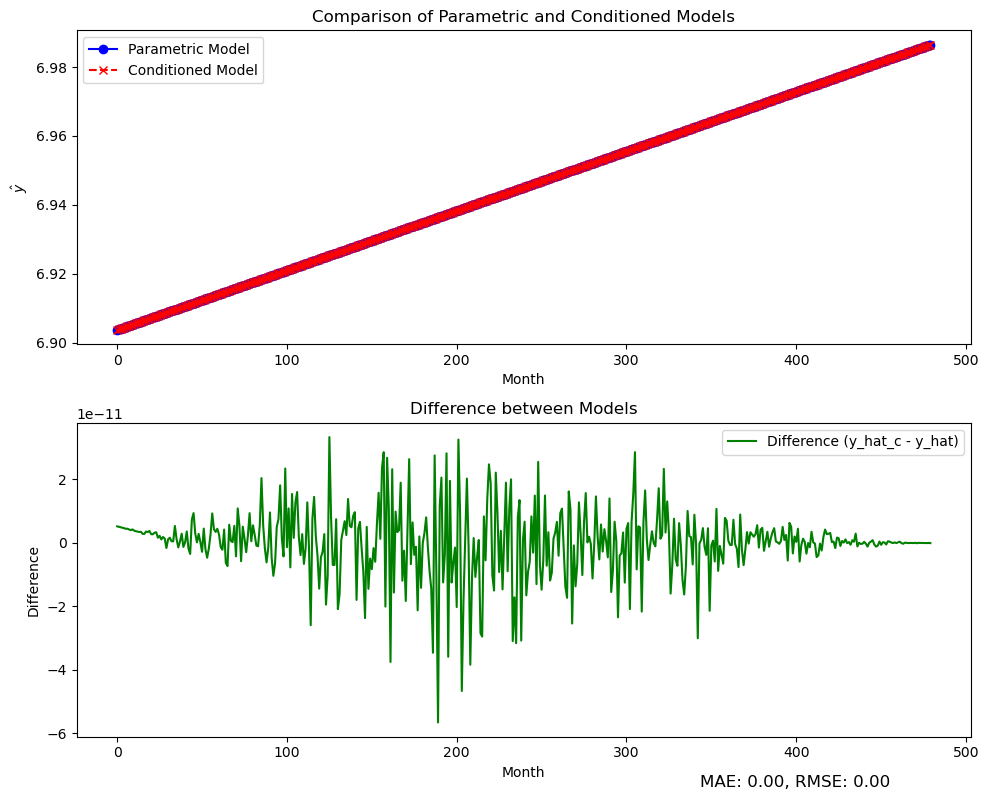

In [9]:
b_0 = 0
y_hat_c = y- Q_yy@B@np.linalg.inv(B.T@Q_yy@B)@(B.T@y-b_0)

y_hat = A0 @ x_hat
e_hat_conditioned = y- y_hat_c

difference = y_hat_c - y_hat

mae = np.mean(np.abs(difference))
rmse = np.sqrt(np.mean(difference**2))

fig, axs = plt.subplots(2, 1, figsize=(10, 8)) 

axs[0].plot(month, y_hat, 'b-', marker='o', label='Parametric Model')
axs[0].plot(month, y_hat_c, 'r--', marker='x', label='Conditioned Model')
axs[0].set_title('Comparison of Parametric and Conditioned Models')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('$\hat{y}$')
axs[0].legend()

axs[1].plot(month, difference, 'g-', label='Difference (y_hat_c - y_hat)')
axs[1].set_title('Difference between Models')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Difference')
axs[1].legend()

plt.figtext(0.8, 0.01, f'MAE: {mae:.2f}, RMSE: {rmse:.2f}', ha='center', fontsize=12)

plt.tight_layout()
plt.show()


**We see from the above that the difference is virtually zero.**

### 1.2. Models with Different Parameters

We try to find a model that can fit the observations with different parameters to the default model. Consider the following two models:

- Model 1: remove the drift parameter $\alpha$ that is proportional to $t$
- Model 2: adding a parameter $\theta$ that is proportional to a periodic trend $\sin(\frac{2\pi}{12}t)$

#### 1.2.1. Set up Models

**Answer the following questions:**

- Write down the functions of $y(t)$ for the above two models.
$$
y_1(t) = \beta
$$

$$
y_2(t) = \alpha t + \beta + \theta \sin(2\pi/12 t) 
$$
- What will you put into the columns of $A$ matrices for these two models?
    - For Model 1 the design matrix will have one column filled with ones (the intercept).
    - For Model 2, the design matrix will have three columns: one filled with one (intercept), one with the time variable (months), and one with $\sin (2\pi/12)t$ for the seasonal component.
    
- Set up you design matrices $A_1$ and $A_2$.

In [10]:
# Set up design matrices
A1= np.ones((month.size,1))

A2=  np.ones((month.size,3))
A2[:,0]=month
A2[:,2]= np.sin((2*np.pi/12)*month)

print(A1.shape)

(480, 1)


#### 1.2.2. Solve the Models

**Answer the following questions:**
- Estimate the parameters with BLUE for all the models: $\hat{x}, Q_{\hat{x}\hat{x}}$.
- Plot the results for all the models (use $\texttt{plot\_result()}$).
- Print the mean of the normalized residuals and its standard deviation.
- Which model fit the observations best? Please give at least three reasons to support your conclusion. In case, the default model reported on [1.1.2.](####-1.1.2.-Reflect-on-Estimation-Results) is deemed the best fit, please provide an explanation. 

In [11]:
# Obtain the estimate of x_0 with BLUE

#Estimate x_hat and Q_x_hat for model 1
x_hat1, Q_x_hat1 = BLUE(A1,y,Q_yy)
print(f'x_hat model 1 = {x_hat1[0]:.2f} m')
# # Print your estimate and its standard deviation
print(f'Q_x_hat model 1 = {np.sqrt(np.diagonal(Q_x_hat1))[0]:.5f} m')

y_hat1 = A1@ x_hat1

e1 = y-y_hat1
e1_mean = np.mean(e1)
PA = A1 @ np.linalg.inv(A1.T @ np.linalg.inv(Q_yy) @ A1) @ A1.T @ np.linalg.inv(Q_yy)
PA_1 = np.eye(len(y)) - PA
Q_ehat1 = PA_1 @ Q_yy @ PA_1.T
sigma_ehat1 = np.diag(Q_ehat1)**.5

e1_std = np.std(e1)

print(f'mean of normalised residuals model 1 = {e1_mean:.4f} [-]')
print(f'std of normalised residuals model 1 = {e1_std:.3f} m')



x_hat model 1 = 6.96 m
Q_x_hat model 1 = 0.00134 m
mean of normalised residuals model 1 = -0.0153 [-]
std of normalised residuals model 1 = 0.043 m


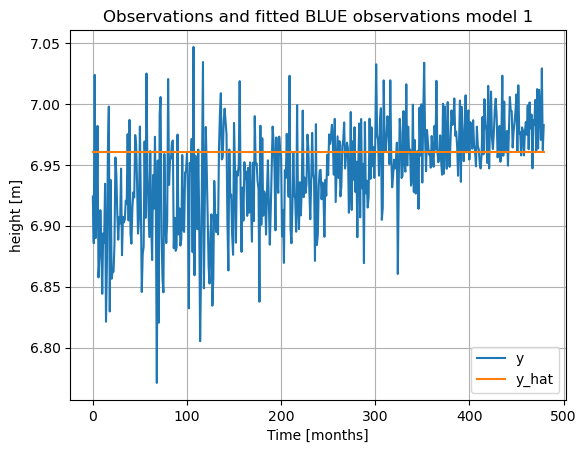

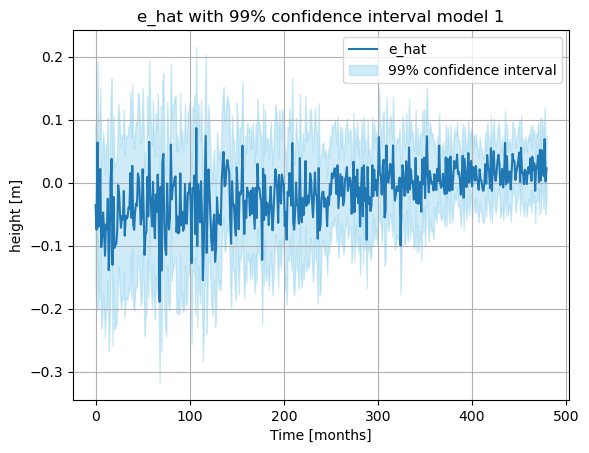

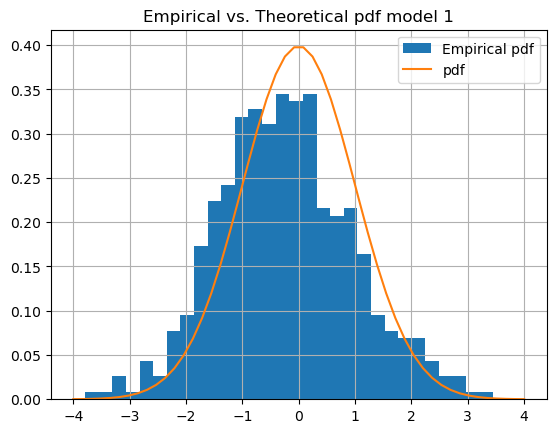

In [12]:
plot_result(y, A1, Q_yy, month, 'model 1');

In [13]:
#model 2
#Estimate x_hat and Q_x_hat for model 2
x_hat2, Q_x_hat2 = BLUE(A2,y,Q_yy)
print('x_hat model 2 = {:.5f} m/month, {:.2f} m, {:.5f} m/month'.format(*x_hat2))
# Print your estimate and its standard deviation
print('Q_x_hat model 2 standard deviation = {:.6f} m/month, {:.5f} m , {:.5f} m/month'.format(*np.sqrt(np.diagonal(Q_x_hat2))))

correlation_coefficient = Q_x_hat2[0, 1] / (std_devs[0] * std_devs[1])
print(f'Correlation coefficient between α and β: {correlation_coefficient:.5f}')

y_hat2 = A2 @ x_hat2
e2 = y - y_hat2
e2_mean = np.mean(e2)

PA = A2 @ np.linalg.inv(A2.T @ np.linalg.inv(Q_yy) @ A2) @ A2.T @ np.linalg.inv(Q_yy)
PA_1 = np.eye(len(y)) - PA
Q_ehat2 = PA_1 @ Q_yy @ PA_1.T  # covariance matrix of residuals
sigma_ehat2 = np.diag(Q_ehat2) ** 0.5  # std of each residual
e2_std = np.std(e2)
print(f'mean of normalised residuals model 2 = {e2_mean:.6f} [-]')

print(f'std of normalised residuals model 2 = {e2_std:.2f} m')

x_hat model 2 = 0.00017 m/month, 6.90 m, 0.00114 m/month
Q_x_hat model 2 standard deviation = 0.000011 m/month, 0.00382 m , 0.00190 m/month
Correlation coefficient between α and β: -0.93663
mean of normalised residuals model 2 = -0.000087 [-]
std of normalised residuals model 2 = 0.04 m


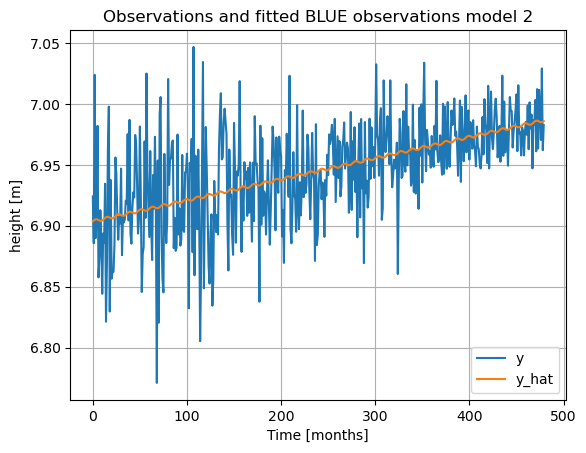

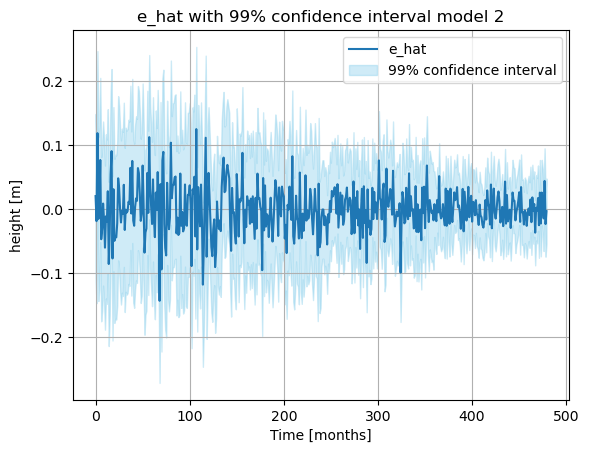

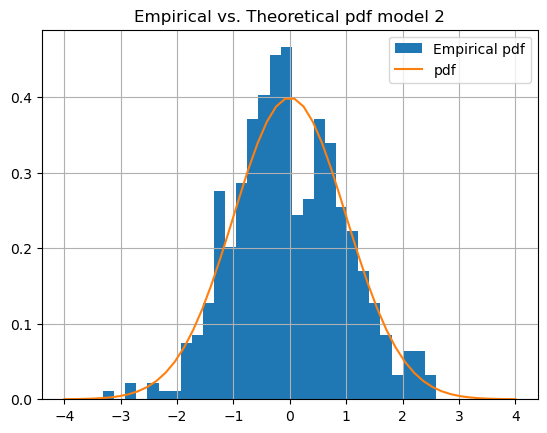

In [14]:
plot_result(y, A2, Q_yy, month, 'model 2');

**From the above results it is clear that Model 1 is the worse, since it only considers the intercept, without any trend. Now, between Model 2 and Model 0, we see that Model 2 is (slightly) better. Firstly, the mean of the normalized residuals of Model 2 is closer to zero, i.e.: they are more symmetrically distributed around zero, indicating a less systematic bias. Secondly, Model 2 includes a periodic term to account for the seasons of the year, which are expected to exist. Lastly, even though we have added this periodic term, we see that the the standard deviation and correlation of the parameters $\alpha$ and $\beta$ did not change. This lack of change together with a decrease in the absolute value of the mean of the normalized residuals indicate that the extra periodic term captures seasonal variations in sea level rise without compromising the precision or the relationship between the other parameters.**


## 1.3. Least-Squares Estimator

We use the BLUE in the previous section. Now, we can also try the least-squares (LS) and weighted least-squares (WLS) estimators.

### 1.3.1. Weighted least-Squares

**Please define the function for WLS:**

In [15]:
# Define your weighted least-squares function here
def WLS(A,W,y, Q_yy):
    """ 
    Function to calculate the weighted least-squares 
    """

    # Add your code here
    x_hat = np.linalg.solve(A.T@ W@ A, A.T@ W @ y)
    Q_x_hat = np.linalg.inv(A.T @ W @ A) @ A.T @ W @ Q_yy @ W @ A @ np.linalg.inv(A.T @ W @ A)
    return x_hat, Q_x_hat

### 1.3.2. Least-Squares and Weighted Least-Squares

In this section, we use the best fit model you chose in [1.2.2.](####-1.2.2.-Solve-the-Models) for estimation. 

**Answer the following questions:**
- Define a weight matrix yourself (other than an $\sigma^2I_m$ and $Q_{yy}^{-1}$) for WLS.
- Apply LS and WLS, compare your estimates and standard deviations with those of BLUE (Remember the units!).

In [16]:
w = np.random.rand(480) 

W = np.diag(w)

def LS(A,y, Q_yy):
    x_hat = np.linalg.solve(A.T @ A, A.T @ y)
    Q_x_hat = np.linalg.inv(A.T @ A) @ A.T @ Q_yy @ A @ np.linalg.inv(A.T @ A)
    return x_hat, Q_x_hat

X_hat_LS, Q_x_hat_LS= LS(A2,y, Q_yy)
X_hat_WLS, Q_x_hat_WLS= WLS(A2,W, y, Q_yy)

def compute_std(Q_x_hat):
    return np.sqrt(np.diag(Q_x_hat))

print("Estimates comparison:")
print("LS estimates: {:.6f} m/month, {:.2f} m, {:.5f} m/month".format(*X_hat_LS))
print("WLS estimates: {:.6f} m/month, {:.2f} m, {:5f} m/month".format(*X_hat_WLS))
print("BLUE estimates: {:.6f} m/month, {:.2f} m, {:.5f} m/month".format(*x_hat2))

print("\nStandard deviations comparison:")
print("LS standard deviations: {:.6f} m/month, {:.2f} m, {:.5f} m/month".format(*compute_std(Q_x_hat_LS)))
print("WLS standard deviations: {:.6f} m/month, {:.2f} m, {:.5f} m/month".format(*compute_std(Q_x_hat_WLS)))
print("BLUE standard deviations: {:.6f} m/month, {:.2f} m, {:.5f} m/month".format(*compute_std(Q_x_hat2)))

Estimates comparison:
LS estimates: 0.000169 m/month, 6.90 m, 0.00131 m/month
WLS estimates: 0.000169 m/month, 6.91 m, 0.001661 m/month
BLUE estimates: 0.000173 m/month, 6.90 m, 0.00114 m/month

Standard deviations comparison:
LS standard deviations: 0.000012 m/month, 0.00 m, 0.00237 m/month
WLS standard deviations: 0.000015 m/month, 0.00 m, 0.00276 m/month
BLUE standard deviations: 0.000011 m/month, 0.00 m, 0.00190 m/month


While LS and WLS with randomly assigned weights yield estimates that align with those from BLUE, the random weights would definitely result in less precise and reliable estimates. This is clearly reflected in the larger standard deviations compared to those from BLUE. 

**Answer the following questions and give explanations:**
- Is WLS always a better estimator than LS? Why?
    - No. WLS is more appropriate when the errors in the data have non-constant variance (heteroscedasticity), or when certain observations are known to be more reliable than others. WLS provides better estimates by giving more weight to more reliable observations, i.e: observations with lower variance.
- You may get different WLS estimators by applying different weight matrices. Can you find a WLS estimator that has smaller variance than BLUE? Why?
    - No. By definition, BLUE is the Best estimator meaning the smallest variance among all linear unbiased estimators. 
- If you apply WLS with two different $W$ matrices to solve your unknown, $W_2 = kW_1$, $k\in \mathbb{R}^+$, do you obtain the same estimate $\hat{x}$? And do you obtain the same estimator $\hat{\underline{x}}$? 
    - Yes. Scaling the weights by a constant factor $k$ does not change the relative weights between observations, so both the estimate $\hat{x}$ and the estimator $\hat{\underline{x}}$ remains unchanged.
- If you apply BLUE with two different $Q_{yy}$ matrices to solve your unknown, $Q_{yy,2} = kQ_{yy,1}$, $k\in \mathbb{R}^+$, do you obtain the same estimate $\hat{x}$? And do you obtain the same estimator $\hat{\underline{x}}$?
    - The estimate $\hat{x}$ will remain the same as a positive scalar $k$ does not affect the relative weights of the observations. Therefore, we will also get the same estimator as it is still the BLUE. However, the variance-covariance matrix $Q_{\hat{x}\hat{x}}$ will change since it is inversely proportional to $Q_{yy}$.
    

## 1.4. Constrained Linear Model

If we want to apply constraints on parameters, we can use the constrained linear model. Please consider the Default Model. Now, we constrain the bias parameter in the default model to the first tide gauge measurement $y(0)$. 


**Answer the following questions:**
- What is the shape of the $C$ matrix? How do you define $C$?
    - The $C$ matrix has a shape $N \times d$ where $N$ is the number of parameters (2 in this case), and $d$ is the number of constrains (1 in this case). In this case $C$ is defined as follows    
    $$
    C= \begin{pmatrix}
    0 \\ 1
    \end{pmatrix}
    $$
- What is the redundancy $r$ of the constrained model?
    - The redundancy is given as $r = m - n + d = 480 - 2 + 1 = 479.

- How do you solve this constrained model ($\hat{x}$)?
    - To solve this constrained model first we obtain the BLUE $\hat{x}_u$ and $Q_{\hat{x}_u\hat{x}_u}$, then given $c_0 = y(0)$ we solve
    $$
    \hat{x} = \hat{x}_u - Q_{\hat{x}_u\hat{x}_u}C(C^TQ_{\hat{x}_u\hat{x}_u}C)^{-1}(C^T\hat{x}_u - c_0).
    $$
- How to compute the $Q_{\hat{x}\hat{x}}$ matrix of the constrained estimator? (You can derive it based on error propagation law)
    $$
    Q_{\hat{x}\hat{x}} = Q_{\hat{x}_u\hat{x}_u} - Q_{\hat{x}_u\hat{x}_u} C (C^TQ_{\hat{x}_u\hat{x}_u}C)^{-1} C^T Q_{\hat{x}_u\hat{x}_u}
    $$
- Obtain the constrained estimate and the corresponding standard deviation.
    - Done in the code below.
- How does the standard deviation of the estimator change after we apply the constraint? Try to explain it.
    - The standard deviation of $\beta$ is $0$, showing that the constraint removes all uncertainty associated with it. This is because we are no longer estimating $\beta$ from the data. 
    
    - For $\alpha$, the constraint on $\beta$ can have an indirect effect. By fixing $\beta$, we reduce the degrees of freedom in the model, potentially allowing for a more precise estimation of $\alpha$, as reflected by the decrease in its standard deviation. This can happen because fixing one parameter can reduce the "noise" or variability in estimating the other parameters, as the model no longer needs to account for variations in $\beta$.

In [17]:
C = np.array([[0, 1]])  
C = C.T
c0 = y[0]

def apply_constraint(A, y, Q_yy, C, c0):
    x_hat_u, Q_x_hat_u = BLUE(A, y, Q_yy)
    P = np.linalg.inv(C.T @ Q_x_hat_u @ C)

    Q_x_hat = Q_x_hat_u - Q_x_hat_u @ C @ P @ C.T @ Q_x_hat_u
    
    std_x_hat = np.sqrt(np.diag(Q_x_hat))
    
    return x_hat, std_x_hat

x_hat, std_x_hat = apply_constraint(A0, y, Q_yy, C, c0)
print("Constrained estimate: alpha = {:.5f} m/month, beta = {:.2f} m".format(*x_hat))
print("Standard deviation of the constrained estimators: alpha = {:.8f} m/month, beta = {:.8f} m".format(*std_x_hat))

Constrained estimate: alpha = 0.00017 m/month, beta = 6.90 m
Standard deviation of the constrained estimators: alpha = 0.00000383 m/month, beta = 0.00000000 m


## 2. Testing

In this part of the assignment, you will apply the theory of statistical testing to select the best fit model and conduct the data snooping to detect outliers in the measurements.

### 2.1. Model Selection
#### 2.1.1. Apply Overall Model Test (OMT) to check whether $\mathcal{H}_0$ is accepted

**Answer the following questions:**
- You can apply the OMT based on parametric model and also the conditioned model. How do you compute the OMT statistic with these two types of models and what is the distribution of it?
    - The OMT statistics follows a chi-square $(\chi^2)$ distribution and is computed for both models as
    $$
    T_q = \hat{e}^T Q_{yy}^{-1} \hat{e}.
    $$
    - The difference between $T_{q,cond}$ and $T_{q,param}$ lies in how $\hat{e}$ is computed for both models. 
- Choose a false alarm rate $\alpha$ yourself, what is the critical value corresponding to that?
    - for $\alpha=0.95$ we have a critical value of $428.30$.
- What is the impact on the test if the false alarm rate $\alpha$ is increased?
    - Increasing $\alpha$ reduces the critical value $(CV)$ making it easier to reject the null hypothesis $(H_0)$. This also means that we have an increased chance of Type I errors (false positive) but we reduce the chances of Type II errors (false negative).

- Conduct the OMT based on parametric model and conditioned model. What's your conclusion?
    - The OMT was conducted below for both the parametric model and the conditioned model. Both tests are very similar, with differences in $T_q$ smaller than $1e-7$. The plot done below also show that the residuals of both models are similar; then it makes sense that their OMT would be similar.
    - For both models we have that $H_0$ is accepted for $\alpha < 0.69$; i.e.: if the null hypothesis is true (there is no significant difference between the observations and the models) we do not have sufficient evidence to reject it at the 69% significance level.

In [18]:
def overall_model_test(e0, Q_yy, n, alpha, verbose=True, B=None):
    T_q = e0.T @ np.linalg.inv(Q_yy) @ e0
    m = len(Q_yy)
    q = m - n
    c2 = chi2.ppf(1 - alpha, df=q)

    if verbose:    
        if B is None:
            print("======= Model type: Parametric =======")
        else:
            print("======= Model type: Conditioned =======")
        
        if T_q < c2:
            print(f"Overall Model Test with alpha = {alpha} \nTest statistic: {T_q:.12f} \nCritical value: {c2:.2f} (DoF={q})\n"
                + "T_q < critical value so H_0 is not rejected")
        else:
            print(f"Overall Model Test with alpha = {alpha} \nTest statistic: {T_q:.12f} \nCritical value: {c2:.2f} (DoF={q})\n"
                + "T_q > critical value so H_0 is rejected")
            
        print("========================================")

    return T_q, c2

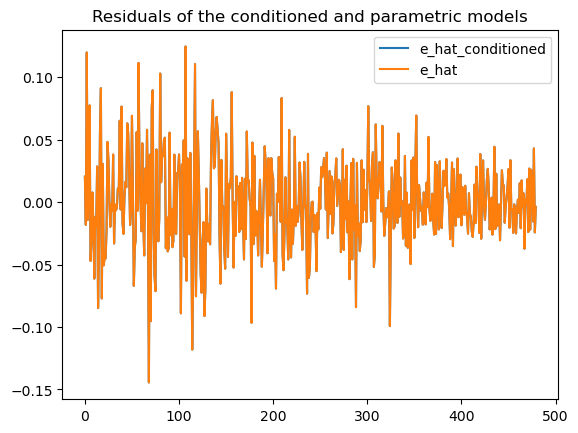

In [19]:
plt.plot(e_hat_conditioned, label="e_hat_conditioned")
plt.plot(e_hat, label="e_hat")
plt.legend()
plt.title("Residuals of the conditioned and parametric models")
plt.show()

In [20]:
for alpha in [0.69, 0.7]:
    overall_model_test(e_hat, Q_yy, 2, alpha, True)
    overall_model_test(e_hat_conditioned, Q_yy, 2, alpha, True, B)


======= Model type: Parametric =======
Overall Model Test with alpha = 0.69 
Test statistic: 462.043827800148 
Critical value: 462.18 (DoF=478)
T_q < critical value so H_0 is not rejected
======= Model type: Conditioned =======
Overall Model Test with alpha = 0.69 
Test statistic: 462.043827786565 
Critical value: 462.18 (DoF=478)
T_q < critical value so H_0 is not rejected
======= Model type: Parametric =======
Overall Model Test with alpha = 0.7 
Test statistic: 462.043827800148 
Critical value: 461.32 (DoF=478)
T_q > critical value so H_0 is rejected
======= Model type: Conditioned =======
Overall Model Test with alpha = 0.7 
Test statistic: 462.043827786565 
Critical value: 461.32 (DoF=478)
T_q > critical value so H_0 is rejected


#### 2.1.2. Apply Generalized Likelihood Ratio (GLR) Test and choose the Best Fit Model
**Answer the following questions:**

- How do you compute the test statistic of GLR test with the parametric model? What is the distribution of it under null hypothesis $\mathcal{H}_0$ where the default model is correct?

    - both the null hypothesis $\mathcal{H}_0$ and $\mathcal{H}_a$  are assumed to be normally distributed, therefor the test statistic of GLR can be computed between the weighted squared norms of residuals, which is known to have a $(\chi^2)$ - distribution if $\mathcal{H}_0$ is true. 

    $$T_q= \hat{e}_0^T Q_{yy}^{-1} \hat{e}_0- \hat{e}_a^T Q_{yy}^{-1} \hat{e}_a$$


- Why the GLR test statistic is always positive? 
    - Because you can rewrite the above equation as:
    
    $$T_q= \lVert \hat{y}_0 - \hat{y}_a \rVert ^2_{Q_{yy}^{-1}}$$
    the difference between $ \hat{y}_0 - \hat{y}_a $ is the squared norm which is always possitive

    
- Choose a false alarm rate $\alpha$ yourself, what is the critical value corresponding to that?
$\alpha$ = 0.7   $k_{\alpha}= 0.06 $

- What is the impact on the GLR test if the false alarm rate $\alpha$ is increased?

    - Increasing $\alpha$ reduces the critical value $(CV)$ making it easier to reject the null hypothesis $(H_0)$. This also means that we have an increased chance of Type I errors (false positive) but we reduce the chances of Type II errors (false negative).
- Can you choose a best fit model from the models given in [1.2.](###-1.2.-Models-with-Different-Parameters) based on the test statistics of the GLR test? Explain your reason. 
    - choosing a reasonable 

_Your Answer/s_

-

In [21]:
# Create your function here to compute the GLR test statistics
def generalized_likelihood_ratio_test(e0, ea, Q_yy, q, alpha, verbose=True, B=None):
    T_q = (e0.T @ np.linalg.inv(Q_yy) @ e0) - (ea.T @ np.linalg.inv(Q_yy) @ ea)
    c2 = chi2.ppf(1 - alpha, df=q)

    if verbose:    
        if B is None:
            print("======= Model type: Parametric =======")
        else:
            print("======= Model type: Conditioned =======")
        
        if T_q < c2:
            print(f"GLR with alpha = {alpha} \nTest statistic: {T_q:.12f} \nCritical value: {c2:.2f} (DoF={q})\n"
                + "T_q < critical value so H_0 is not rejected")
        else:
            print(f"Overall Model Test with alpha = {alpha} \nTest statistic: {T_q:.12f} \nCritical value: {c2:.2f} (DoF={q})\n"
                + "T_q > critical value so H_0 is rejected")
            
        print("========================================")

    return T_q, c2

In [22]:
# Apply GLR Test

# model A0 and A1
generalized_likelihood_ratio_test(e1, e_hat, Q_yy, q=1, alpha=0.1, verbose=True, B=None) 
# model A0 and A2
generalized_likelihood_ratio_test(e_hat, e2, Q_yy, q=1, alpha=0.1, verbose=True, B=None)


print("Based upon the GLR test we choose our original model A0 over the other models")
print("we should choose alpha not to big to reduce the probability of false alarm")

======= Model type: Parametric =======
Overall Model Test with alpha = 0.1 
Test statistic: 251.277831220080 
Critical value: 2.71 (DoF=1)
T_q > critical value so H_0 is rejected
======= Model type: Parametric =======
GLR with alpha = 0.1 
Test statistic: 0.364309015775 
Critical value: 2.71 (DoF=1)
T_q < critical value so H_0 is not rejected
Based upon the GLR test we choose our original model A0 over the other models
we should choose alpha not to big to reduce the probability of false alarm


### 2.2. Data Snooping
We use a different dataset SGDA_[location]_outlier.csv for this exercise, which contains several outliers compared with the observations we used before. Your task is to find out these outliers with data snooping. 

1. Load the dataset and estimate the parameters with the best fit model you choose in [2.1.2.](#212-apply-generalized-likelihood-ratio-glr-test-and-choose-the-best-fit-model), then plot the figures required in [1.1.2.](####-1.1.2.-Reflect-on-Estimation-Results). 

We choose to work with $A_0$ model

 

2. Describe the impact of the outliers on the curve fitting.

    - We can see the outliers in the timeseries. We can also see that the residuals of the outliers are outside the confidence intervals

3. Apply the OMT with $\alpha=0.01$. What is the outcome of the test?

    - We see that our null hypothesis is now rejected.

_Your Answer/s_

-

x_hat outlier = 0.00017 m/month, 6.91 m
Q_x_hat  standard deviation = 0.000011 m/month, 0.00381 m 


======= Model type: Parametric =======
Overall Model Test with alpha = 0.01 
Test statistic: 609.729330767739 
Critical value: 552.86 (DoF=478)
T_q > critical value so H_0 is rejected


(609.7293307677394, 552.8558213134843)

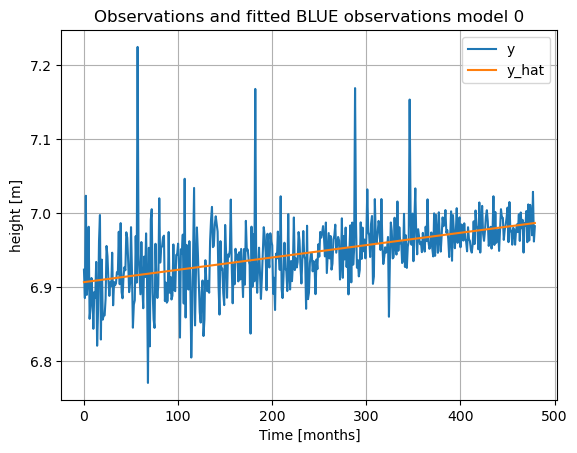

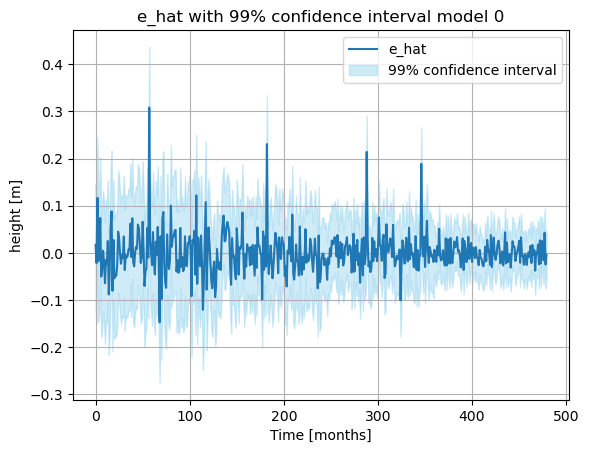

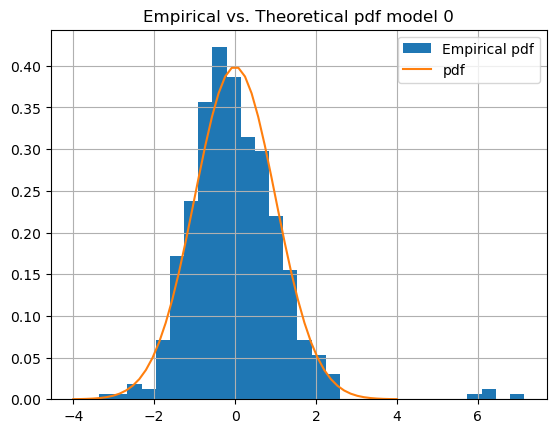

In [23]:
# Load the dataset
Data_outlier = np.genfromtxt('Datasets_with_outlier/SGDA_Hoek_van_Holland_outlier.csv',delimiter=',', skip_header=1)



y_out = Data_outlier[:,2]
month_out = Data_outlier[:,1]

STD_out = Data_outlier[:,3]
Q_yy_out= np.diag(STD_out*STD_out)
# Estimate the model parameters
#model 0
#Estimate x_hat and Q_x_hat with model 0
x_hat_out, Q_x_hat_out = BLUE(A0,y_out,Q_yy)
print('x_hat outlier = {:.5f} m/month, {:.2f} m'.format(*x_hat_out))
# Print your estimate and its standard deviation
print('Q_x_hat  standard deviation = {:.6f} m/month, {:.5f} m '.format(*np.sqrt(np.diagonal(Q_x_hat_out))))

y_hat_out = A0 @ x_hat_out
e_out = y_out - y_hat_out
PA_out = A0 @ np.linalg.inv(A0.T @ np.linalg.inv(Q_yy) @ A0) @ A0.T @ np.linalg.inv(Q_yy)
PA_1_out = np.eye(len(y_out)) - PA_out
Q_ehat_out = PA_1_out @ Q_yy_out @ PA_1_out.T
plot_result(y_out, A0, Q_yy, month_out, 'model 0')

# Apply OMT
overall_model_test(e_out, Q_yy, 2, alpha=0.01, verbose=True,B=None)


In [24]:
sigma_ei= np.diag(Q_ehat_out)**0.5
     
w= e_out/sigma_ei  #eq on page 131 reader 
T_q= w**2  #eq on page 130 reader

k = chi2.ppf(1 - alpha, df=1) #use chi2 distribution
 
w_i=np.argmax(T_q[T_q < k]) #get the index of max value of T_q that is greater than k, so that i just take one value but the largest
print(w_i)

72


4. Describe the steps of data snooping. 

    - w use the w-test statistic $$\bar{w}_=\frac{\hat{e}_i}{\sigma_{\hat{e}_i}}$$
    - $T_{q=1}=w^2$ The critical value is taken from the Chi-square distribution, where we reject $H_0$ if  $T_{q=1}>k_{\alpha}$
    - We take the index of of the largest value of $T_q$ that responds to $T_{q=1}>k_{\alpha}$ and we remove that data point
    - We then check if the new data with belonging model is accepted by the Overall Model Test
    - If not we loop and repeat the above steps until the H0 model is accepted 
    
    
5. Carry out the data snooping; stop the interation until OMT is not rejected or no outliers are detected. Please set the false alarm rate ($\alpha$) for both $w$-test and overall model test to $0.01$. During which months are outliers detected? (_Please remember to save a copy of the observations, the corresponding $Q_{yy}$-matrix, $A$-matrix and time vector $t$, because data snooping will overwrite them._)

6. Outliers can be revealed by plotting the observations with and without outliers in the same figure. Plot the figure, and identify which outliers are detected and which are not. Try to explain that.

    - removed months: [288. 346.] and removed residuals: [0.21415283 0.18901191]
    They can be seen in the plot. These two outliers have been removed because the have the highest $T_q= (\frac{\hat{e}_i}{\sigma_{\hat{e}_i}})^2$
    Its because of the lower $sigma_yy$ in the later months, meaning that  $\sigma_{\hat{e}_i}$ will be lower

7. Change the false alarm rate $\alpha$ of the overall model test to $0.1$ and repeat Question 5 and 6. What happens on the outcome of the data snooping? Please explain that.
- We see that more outliers have been removed. The removed months are: 57, 288 and 346 and removed observations: 7.22504029, 7.16936807 and 7.15390179 and removed residuals: 0.30835675 , 0.21415283 , 0.18901191.
Because of the higher alpha its needs to have more outliers removed inorder for $H_0$ to be accepted

_Your Answer/s_

-

In [26]:
# Carry out data snooping

#made a new overall model test function just so it doesnt print loads stuff many times
def overall_model_test_2(e0, Q_yy, n, alpha):
    T_q = e0.T @ np.linalg.inv(Q_yy) @ e0
    m = len(Q_yy[:,0])
    q = m - n
    c2 = chi2.ppf(1 - alpha, df=q)
    return T_q, c2

def w_test(y, A0, t, e_out, Q_yy, Q_ehat_out, y_hat, alpha):
    # Compute sigma_e_hat
    sigma_ei = np.diag(Q_ehat_out) ** 0.5

    w = e_out / sigma_ei  # Equation on page 131 of the reader
    T_q = w ** 2  # Equation on page 130 of the reader

    k = chi2.ppf(1 - alpha, df=1)  # Use chi2 distribution

    if np.max(T_q) > k:  # Check if the maximum value of T_q is greater than k
        w_i = np.argmax(T_q)  # Get the index of max value of T_q
    else:
        w_i = None

    if w_i is not None:  # If w_i is not None, meaning T_q > k
        # Delete the element with this index from the data
        new_y = np.delete(y, w_i)
        new_e_hat = np.delete(e_out, w_i)
        new_y_hat = np.delete(y_hat, w_i)
        Q_yi = np.diag(Q_yy)
        new_Q_yy = np.delete(Q_yi, w_i)
        Q_yy_new = np.diag(new_Q_yy)

        new_sig_ei = np.delete(sigma_ei, w_i)
        Q_e_new = np.diag(new_sig_ei)

        A_out = np.delete(A0, w_i, axis=0)
        t_out = np.delete(t, w_i)
    else:
        # If T_q <= k, return the original data
        new_y, A_out, t_out, new_e_hat, new_y_hat, Q_yy_new, Q_e_new = y, A0, t, e_out, y_hat, Q_yy, np.diag(sigma_ei)

    return new_y, A_out, t_out, new_e_hat, new_y_hat, Q_yy_new, Q_e_new

#write data snoopin function
def data_snooping(y_out,A0_out,t_out, e_out, Q_yy_out, Q_ehat_out, y_hat_out, alpha):
    T_q, c2= overall_model_test_2(e_out, Q_yy_out, 2, alpha) #set off the while loop by initiating T_q to be greater than c2
    counter = 0
    while T_q > c2:
        y_out, A0_out, t_out, e_out, y_hat_out, Q_yy_out, Q_ehat_out= w_test(y_out,A0_out,t_out, e_out, Q_yy_out, Q_ehat_out, y_hat_out,alpha)
        x_hat_out, Q_x_hat_out = BLUE(A0_out,y_out,Q_yy_out)
        y_hat_out = A0_out @ x_hat_out
        e_out = y_out - y_hat_out
        #compute Q_e_hat
        PA = A0_out @ np.linalg.inv(A0_out.T @ np.linalg.inv(Q_yy_out) @ A0_out) @ A0_out.T @ np.linalg.inv(Q_yy_out)
        PA_1 = np.eye(len(y_hat_out)) - PA
        Q_ehat_out = PA_1 @ Q_yy_out @ PA_1.T
        #test the mode OMT
        T_q, c2= overall_model_test_2(e_out, Q_yy_out, 2, alpha)  
        counter += 1  
    
    return y_out,A0_out, t_out, e_out, y_hat_out, Q_yy_out,T_q, c2



In [27]:
y_out01, A0_out01,t_out01,  e_out01, y_hat_out01, Q_yy_out01,T_q01, c201=data_snooping(y_out,A0,month_out, e_out, Q_yy_out,Q_ehat_out, y_hat_out, alpha=0.01)



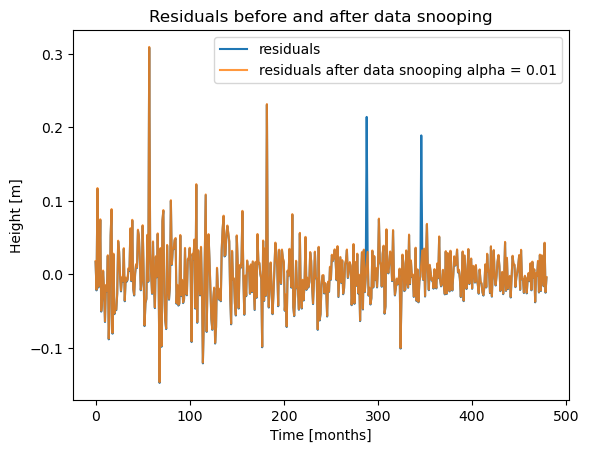

In [47]:
plt.plot(month_out, e_out, label='residuals')
plt.plot(t_out01, e_out01, label='residuals after data snooping alpha = 0.01', alpha=0.8)
plt.xlabel('Time [months]')
plt.ylabel('Height [m]')
plt.title('Residuals before and after data snooping')
plt.legend()

In [38]:
def find_removed_elements(t_out, y_out, t_new, y_new):
    removed_indices = []
    
    for i, (t, y) in enumerate(zip(t_out, y_out)):
        if t not in t_new or y not in y_new:
            removed_indices.append(i)
    
    return removed_indices

check = find_removed_elements(month_out, y_out, t_out01, y_out01)
print(f'removed months: {month_out[check]} and removed observations: {y_out[check]} and removed residuals: {e_out[check]}')

removed months: [288. 346.] and removed observations: [7.16936807 7.15390179] and removed residuals: [0.21415283 0.18901191]


removed months: [ 57. 288. 346.] and removed observations: [7.22504029 7.16936807 7.15390179] and removed residuals: [0.30835675 0.21415283 0.18901191]


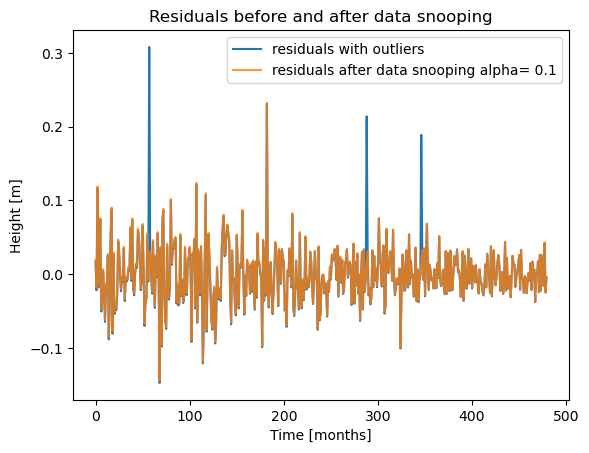

In [49]:
# Carry out data snooping (with different alpha)

y_out_1, A0_out_1,t_out_1,  e_out_1, y_hat_out_1, Q_yy_out_1,T_q_1, c205=data_snooping(y_out,A0,month_out, e_out, Q_yy_out,Q_ehat_out, y_hat_out, alpha=0.1)



# Plot
plt.plot(month_out, e_out, label='residuals with outliers')
plt.plot(t_out_1, e_out_1, label='residuals after data snooping alpha= 0.1', alpha=0.8)
plt.xlabel('Time [months]')
plt.ylabel('Height [m]')
plt.title('Residuals before and after data snooping')
plt.legend()

removed_indx = find_removed_elements(month_out, y_out, t_out_1, y_out_1)
print(f'removed months: {month_out[removed_indx]} and removed observations: {y_out[removed_indx]} and removed residuals: {e_out[removed_indx]}')

## 3. Introduction to DIA theory
In the previous sections, we explored estimation and testing theory separately. This part dives into DIA theory, which combines these concepts. We will plot the partitioning of the misclosure space and the distribution of the DIA estimator. You can read [1] to learn more details about the DIA estimator.

[[1] Teunissen, P.J.G. Distributional theory for the DIA method. J Geod 92, 59–80 (2018)](https://link.springer.com/article/10.1007/s00190-017-1045-7).


### 3.1. DIA Estimator

**Answer the following questions:**

- DIA estimator is developed to combine the estimation and testing scheme. Please explain why this combination is necessary. 
- Based on formula (32) in [1], explain how this combination is achieved.

_Your Answer/s_

-

### 3.2. Partitioning of the Misclosure Space

In the testing process, misclosure vector $t$ plays a crucial role in determining the test outcome. As described by (27) and (28) in [1], the misclosure space can be partitioned based on the test outcomes (data snooping is chosen for this part). Here, we will illustrate this partitioning of the misclosure space by Monte Carlo simulation. The Python script for this simulation is provided below. Please review the script.

**Answer the following questions:**
- If we change the false alarm rate $\alpha$ from $0.05$ to $0.005$, how will the plot of the partitioning change?


- To generate the above plot, we do not compare the $w$-test statistic with a critical value but simply accept the hypothesis with the largest $w$-test statistic. How would the plot looks like if we accept the alternative hypothesis $\mathcal{H}_a$ whose $w$-test statistic is largest and larger than the critical value?
- Modify the code and plot the partitioning of the model selection.
- Repeat the previous two steps with another $B$ matrix (using $\texttt{scipy.linalg.null\_space()}$). What happens on the partitions? Try to explain why $\mathcal{P}_0$ is a circle.

_Your Answer/s_

-

In [31]:
from DIA_functions import *

# To obtain a 2D misclosure space, we consider only the first 4 observations. 
m = 4

# Adapt the A and B-matrix for m=4
A_DIA =  
B_DIA = 

# Adapt the Qyy and Qtt-matrix for m=4
Q_yy_DIA = 
Q_tt_DIA = 

# Datasnooping is used, and thus, create the columns of C-matrix
C_DIA = 

# Get the required "DIA" matrices to compute the DIA paritioning and PDF
Pcti, Li = compute_DIA_matrices(A_DIA, B_DIA, Q_yy_DIA, Q_tt_DIA, C_DIA)

# Plot partitioning of the misclosure space with the alphas
plot_partitionied_2D_misclosure_space(Pcti, Q_tt_DIA, Q_yy_DIA, alpha=...)
plot_partitionied_2D_misclosure_space(Pcti, Q_tt_DIA, Q_yy_DIA, alpha=...)

SyntaxError: invalid syntax (1422693714.py, line 7)

In [ ]:
# Repeat with different B-matrix

### 3.3. Samples of $t$ in the Misclosure Space

After the misclosure space has been illustrated. The misclosure vector $t$ can be generated differently under each hypothesis $\mathcal{H}$. Hence, please plot the cloud of samples of $t$ on to the misclosure for the null hypothesis $\mathcal{H}_0$ and one of the alternative hypotheses $\mathcal{H}_a$ (you can choose!) with a bias of $0.3$ m, and $\alpha=0.005$. __Note:__ Please use your $B$-matrix (not the one from $\texttt{scipy.linalg.null\_space()}$).

To create the cloud of $t$ samples (we use here $10^6$), you can use this function: $\texttt{np.random.multivariate\_normal()}$ from Numpy.

**Answer the following questions:**
- How do you compute the mean of the $t$ under $\mathcal{H}_a$?
- Where is the cloud of samples found under $\mathcal{H}_0$ and $\mathcal{H}_a$? Try to explain why is centered or not in the misclosure space.
- Under $\mathcal{H}_0$, what is the probability of correct acceptance and false alarm with $\alpha=0.05$? Is level of significance $\alpha$ same as the false alarm?
- Under $\mathcal{H}_a$, what is the probability of correct detection, missed detection with $\alpha=0.05$ and bias of $0.3$ m? And the probability of correct identification, wrong identification? 


_Your Answer/s_

-

In [ ]:
# Plot the cloud under H0
nb_samples_t_H0 = 10**6  # number of samples of the misclosure vector t under H0 to be generated
mean_t_H0 = ...
samples_t_H0 = ...

In [ ]:
# Plot the cloud under Ha
nb_samples_t_Ha = 10**6  # number of samples of the misclosure vector t under Ha to be generated
meant_t_Ha = ...
samples_t_Ha = ...

In [ ]:
# Compute the indicator matrix for samples of t, which is a [nb_samples_t * 4] matrix indicating the partitionings that the t_samples lies in. The row with all false means the corresponding t_sample lies in P0.
indicator_t_H0 = compute_indicator_function(Pcti, samples_t_H0, Q_tt_DIA, ...) 
indicator_t_Ha = compute_indicator_function(Pcti, samples_t_Ha, Q_tt_DIA, ...)

# Then the required probabilities based on the indicator matrix

In [ ]:
# Under H0: correct acceptance and false alarm 

In [ ]:
# Under Ha: correct detection, missed detection, correct identification and wrong identification 

### 3.4. Samples of DIA-Estimator
The probability density function (PDF) of the DIA estimator can either be computed with theorem (see section 3 in [1]) or be generated by Monte Carlo simulation. In this part, we apply the second approach to generate the samples of DIA estimator and show the histogram of it. __Note:__ Please use your $B$-matrix (not the one from $\texttt{scipy.linalg.null\_space()}$).

To plot 2D histograms, you can use this function: $\texttt{plt.hist2d()}$ from Matplotlib.

**Answer the following questions:**
- The samples of the DIA estimator are generated by simulating the samples of the observations and then carrying out the estimation and statistical testing. Several lines of code in the function $\texttt{obtain\_DIA\_samples\_under\_H()}$ are missing. Please complete this function to generate samples of the DIA estimator.
- Plot the histogram of the samples (set density as True) under $\mathcal{H}_0$ and any one of the alternative hypotheses $\mathcal{H}_a$ with a bias of $0.3$ m. Do they follow the Gaussian distribution and are they unbiased? Try to explain why these distributions may deviate from normality.
- Repeat the previous step with another $B$-matrix. What happens? Try to explain the observed changes.


_Your Answer/s_

-

In [ ]:
def obtain_DIA_samples_under_H(Q_yy, A, B, C, x, b, Pcti, Li, alpha, nb_samples_x_DIA):
    
    # Function to obtain the samples of the DIA estimator
 
    # Input
    # vc-matrix of the observable                          Q_yy
    # The design matrices of unknowns and model error      A,C
    # BTA = 0                                              B
    # The true values of unknown and bias                  x,b
    # The projection matrices of the cti vectors           Pcti
    # The Li-terms                                         Li
    # The level of significnace of the OMT                 alpha
    # The number of samples of the DIA esrimator           nb_samples_x_DIA

    # Output 
    # The samples of the DIA estimator                     samples_DIA_H

    # Get the number of alternative hypotheses (k), the redundancy (r), and the dimension of the unknown vector (n)
    k = Pcti.shape[0]
    r = B.shape[1]
    n = A.shape[1]

    design_mat = np.hstack((A,C))
    unknown = np.vstack((x,b))
    mean_y = (design_mat @ unknown).T[0]

    # !!! Generate nb_samples_x_DIA samples of the observable y
    samples_y =

    Q_yy_inv = linalg.inv(Q_yy)
    A_plus = linalg.inv(A.T @ Q_yy_inv @ A) @ A.T @ Q_yy_inv

    # !!! Obtain samples of x_hat_0 and t from samples of y
    samples_x =
    samples_t =

    # !!! Compute threshold for the OMT
    threshold_squared = 

    # Compute the OMT statistics
    Q_tt = B.T @ Q_yy @ B
    invQ_tt = linalg.inv(Q_tt)
    omt_test = np.sum((samples_t.T @ invQ_tt) * samples_t.T, axis=1)

    # Compute the indicator functions for which the samples are outside the acceptance region P0
    i_outside_P0_bool = omt_test > threshold_squared
    i_outside_P0 = i_outside_P0_bool.astype(int)
    indices_i_P0 =  np.nonzero(i_outside_P0)

    # Compute the squared w-tests
    samples_t_outside_P0 = samples_t[:,i_outside_P0_bool].T
    nb_samples_outside_P0 = np.sum(i_outside_P0)

    computed_squared_wtest = np.zeros((nb_samples_outside_P0, k))
    for idx in range(0, k):
        Pcti_t = Pcti[idx] @ samples_t_outside_P0.T
        computed_squared_wtest[:,idx] = np.sum((Pcti_t.T @ invQ_tt) * Pcti_t.T, axis=1)

    # Create the array with the indicator functions for each partition
    max_indices_squared_wtest = computed_squared_wtest.argmax(axis=1)

    # Place the indices into a larger vector
    i_Pi_arr = np.zeros((nb_samples_x_DIA)) - 1
    for idx in range(0,nb_samples_outside_P0):
        i_Pi_arr[indices_i_P0[0][idx]] = max_indices_squared_wtest[idx]
    
    samples_x_bar = np.zeros((n,nb_samples_x_DIA))
    for idx_x in range(0,nb_samples_x_DIA):

        # idx_p gives the index of the partition
        idx_p = int(i_Pi_arr[idx_x])

        # Get samples of DIA, see formula (13) in [1]
        if idx_p == -1:
            # !!! DIA samples when t lies inside P0
            samples_x_bar[:, idx_x] = 
        else:
            # !!! DIA samples when t lies inside Pi
            samples_x_bar[:, idx_x] =
    
    return samples_x_bar

In [ ]:
# Configuration variables
nb_samples_x_DIA = 10 ** 6               # number of samples of the DIA estimator to be generated

# Get the samples of the DIA estimator under the null hypothesis H0 (H0 is true, i.e. the observable follows the distribution of H0)
c_0 = np.zeros((m,1))
x = np.zeros((2,1))
DIA_samples_H0 = obtain_DIA_samples_under_H(Q_yy_DIA, A_DIA, B_DIA, c_0, x, 0, Pcti, Li, alpha=..., nb_samples_x_DIA)

# Get the samples of the DIA estimator under the chosen alternative hypothesis


# Plot the histogram of the samples